In [1]:
# Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/train.zip > /dev/null
!unzip gdrive/My\ Drive/test.zip > /dev/null

In [4]:
# Train path and Validation path

train_path = '/content/train'
valid_path = '/content/test'

In [5]:
os.listdir(train_path)

['NORMAL', 'PNEUMONIA']

In [6]:
os.listdir(valid_path)

['NORMAL', 'PNEUMONIA']

In [7]:
os.listdir(train_path + '/NORMAL')[0]

'NORMAL-5740995-0001.jpeg'

In [8]:
normal = train_path + '/NORMAL' + '/NORMAL-5740995-0001.jpeg'

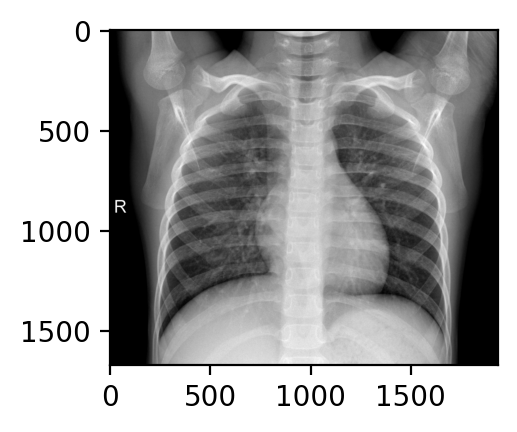

In [9]:
# Healthy Lungs

plt.figure(figsize=(2.5,2.5),dpi=200)
normal_img = cv2.imread(normal)
plt.imshow(normal_img)
plt.show()

In [10]:
os.listdir(train_path + '/PNEUMONIA')[0]

'VIRUS-8841513-0002.jpeg'

In [11]:
pneumonia = train_path + '/PNEUMONIA' + '/VIRUS-8841513-0002.jpeg'

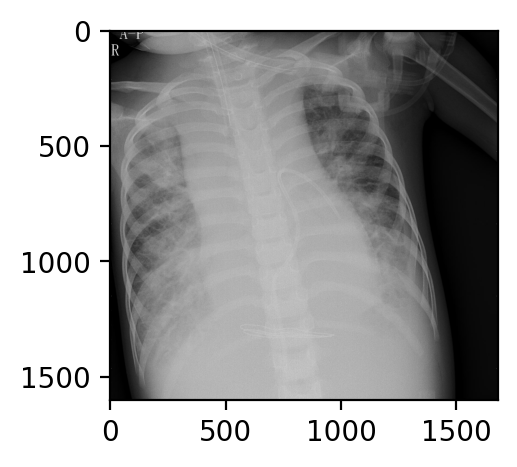

In [12]:
# Lungs with Pneumonia

plt.figure(figsize=(2.5,2.5),dpi=200)
pneumonia_img = cv2.imread(pneumonia)
plt.imshow(pneumonia_img)
plt.show()

In [13]:
# Healthy Lung Shape

normal_img.shape

(1669, 1936, 3)

In [14]:
# Pneumonia Lung shape

pneumonia_img.shape

(1600, 1680, 3)

In [15]:
# Number of train images of healthy lungs

len(os.listdir(train_path + '/NORMAL'))

1349

In [16]:
# Number of train images of lungs with pneumonia

len(os.listdir(train_path + '/PNEUMONIA'))

3883

In [17]:
# Define image shape and batch size 

image_shape = (300, 300, 3)
batch_size = 32


In [18]:
# Import models and layers

from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
train_datagen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10, 
                               rescale=1/255, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest' 
                              )

valid_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(valid_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')



Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience = 2)

In [21]:
vgg_model = VGG16(include_top=False, input_shape=image_shape, weights = 'imagenet')

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output)

58900480/58889256 [==============================] - 1s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              epochs=40, 
                              verbose=1, 
                              callbacks = [early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/40
164/164 [==============================] - 246s 1s/step - loss: 0.3540 - accuracy: 0.9052 - val_loss: 0.3866 - val_accuracy: 0.8205
Epoch 2/40
164/164 [==============================] - 193s 1s/step - loss: 0.1179 - accuracy: 0.9551 - val_loss: 0.1173 - val_accuracy: 0.9696
Epoch 3/40
164/164 [==============================] - 192s 1s/step - loss: 0.1068 - accuracy: 0.9583 - val_loss: 0.1122 - val_accuracy: 0.9647
Epoch 4/40
164/164 [==============================] - 190s 1s/step - loss: 0.0857 - accuracy: 0.9669 - val_loss: 0.1412 - val_accuracy: 0.9455
Epoch 5/40
164/164 [==============================] - 189s 1s/step - loss: 0.1120 - accuracy: 0.9576 - val_loss: 0.1508 - val_accuracy: 0.9391


In [24]:
from tensorflow.keras.models import load_model
model.save('pneumonia_detector.h5')

In [25]:
losses = pd.DataFrame(model.history.history)

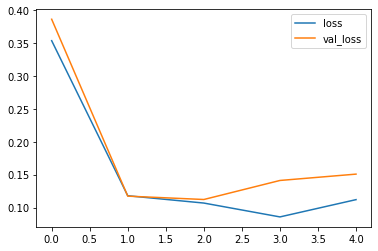

In [26]:
losses[['loss','val_loss']].plot()